In [1]:
import time
import numpy as np
import torch

from sbi import utils as utils
from cost_aware_snpe_c import CostAwareSNPE_C
from sbi.inference.snpe.snpe_c import SNPE_C
from sbi.utils.torchutils import *
from sbi.utils import process_prior
from sbi.utils.user_input_checks import *
from simulators import temporal_sir

from hydra import compose, initialize
import hydra

import gpytorch
from gpytorch.models import ExactGP
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood

from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="configs", version_base=None)
cfg = compose(config_name="train")

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
def MMD_unweighted(x, y, lengthscale):
    """ Approximates the squared MMD between samples x_i ~ P and y_i ~ Q
    """

    m = x.shape[0]
    n = y.shape[0]

    z = torch.cat((x, y), dim=0)

    K = kernel_matrix(z, z, lengthscale)

    kxx = K[0:m, 0:m]
    kyy = K[m:(m + n), m:(m + n)]
    kxy = K[0:m, m:(m + n)]

    return (1 / m ** 2) * torch.sum(kxx) - (2 / (m * n)) * torch.sum(kxy) + (1 / n ** 2) * torch.sum(kyy)


def median_heuristic(y):
    a = torch.cdist(y, y)**2
    return torch.sqrt(torch.median(a / 2))


def kernel_matrix(x, y, l):
    d = torch.cdist(x, y)**2

    kernel = torch.exp(-(1 / (2 * l ** 2)) * d)

    return kernel

In [4]:
def c2st(
    X: torch.Tensor,
    Y: torch.Tensor,
    seed: int = 1,
    n_folds: int = 5,
    scoring: str = "accuracy",
    z_score: bool = True,
    noise_scale: Optional[float] = None,
) -> torch.Tensor:
    """Classifier-based 2-sample test returning accuracy

    Trains classifiers with N-fold cross-validation [1]. Scikit learn MLPClassifier are
    used, with 2 hidden layers of 10x dim each, where dim is the dimensionality of the
    samples X and Y.

    Args:
        X: Sample 1
        Y: Sample 2
        seed: Seed for sklearn
        n_folds: Number of folds
        z_score: Z-scoring using X
        noise_scale: If passed, will add Gaussian noise with std noise_scale to samples

    References:
        [1]: https://scikit-learn.org/stable/modules/cross_validation.html
    """
    if z_score:
        X_mean = torch.mean(X, dim=0)
        X_std = torch.std(X, dim=0)
        X = (X - X_mean) / X_std
        Y = (Y - X_mean) / X_std

    if noise_scale is not None:
        X += noise_scale * torch.randn(X.shape)
        Y += noise_scale * torch.randn(Y.shape)

    X = X.cpu().numpy()
    Y = Y.cpu().numpy()

    ndim = X.shape[1]

    clf = MLPClassifier(
        activation="relu",
        hidden_layer_sizes=(10 * ndim, 10 * ndim),
        max_iter=10000,
        solver="adam",
        random_state=seed,
    )

    data = np.concatenate((X, Y))
    target = np.concatenate(
        (
            np.zeros((X.shape[0],)),
            np.ones((Y.shape[0],)),
        )
    )

    shuffle = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    scores = cross_val_score(clf, data, target, cv=shuffle, scoring=scoring)

    scores = np.asarray(np.mean(scores)).astype(np.float32)
    return torch.from_numpy(np.atleast_1d(scores))

In [5]:
def compute_ks_scores(true_samples, estimated_samples):
    """
    Compute KS test scores between true and estimated posterior samples.
    
    Parameters:
    -----------
    true_samples : numpy.ndarray
        Samples from the true posterior, shape [n_samples, n_dim]
    estimated_samples : numpy.ndarray
        Samples from the estimated posterior, shape [n_samples, n_dim]
        
    Returns:
    --------
    list of floats
        KS test statistic for each dimension
    list of floats
        p-values for each KS test (optional, can be ignored for SBI evaluation)
    """
    
    n_dims = true_samples.shape[1]
    ks_stats = []
    
    # Compute KS test for each dimension
    for dim in range(n_dims):
        ks_stat, p_value = stats.ks_2samp(
            true_samples[:, dim],
            estimated_samples[:, dim]
        )
        ks_stats.append(ks_stat)

    return np.array(ks_stats)

In [3]:
def calc_acc_prob(gp, likelihood, theta, prior_start, k):

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        cost = likelihood(model(theta)).mean

        lower_cost = likelihood(model(prior_start)).mean
    return (lower_cost ** k) / (cost**k)

class GP(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# Temporal SIR

In [6]:
temp_sir = temporal_sir.TemporalSIR()

## Data generation

In [ ]:
# DON'T NEED TO RUN AGAIN IF YOU ALREADY GENERATED THE REFERENCE DATA
N = 50000

temp_sir_theta_npe_large = temp_sir.sample_theta([N]).reshape(-1, temp_sir.theta_dim)
temp_sir_x_npe_large = torch.empty([N, temp_sir.x_dim])
for i in range(N):
    temp_sir_x_npe_large[i, :] = temp_sir(temp_sir_theta_npe_large[i])

temp_sir_obs_theta = torch.tensor([0.5, 0.5])
temp_sir_obs_x = temp_sir(temp_sir_obs_theta)

torch.save(temp_sir_x_npe_large, "data/temp_sir_x_npe_large.pt")
torch.save(temp_sir_theta_npe_large, "data/temp_sir_theta_npe_large.pt")
torch.save(temp_sir_obs_x, "data/temp_sir_obs_x.pt")
torch.save(temp_sir_obs_theta, "data/temp_sir_obs_theta.pt")

## Load data

In [7]:
temp_sir_x_npe_large = torch.load("data_/temp_sir_x_npe_large.pt")
temp_sir_theta_npe_large = torch.load("data_/temp_sir_theta_npe_large.pt")

temp_sir_obs_x = torch.load("data_/temp_sir_obs_x.pt")
temp_sir_obs_theta = torch.load("data_/temp_sir_obs_theta.pt")

## Fit GP

In [373]:
n_train_pair = 200 # number of pairs used to fit GP
n_rep = 50 # number of repeats to get the average cost

In [374]:
X = temp_sir_theta_npe_large[:n_train_pair]

times_train = torch.zeros(n_train_pair)

for i in range(n_train_pair):
    st = time.time()
    for _ in range(n_rep):
        result = temp_sir(temp_sir_theta_npe_large[i])
    et = time.time()
    times_train[i] = (et - st) / n_rep

# save GP training samples
torch.save(X, "data/temp_sir_gp_x.pt")
torch.save(times_train, "data/temp_sir_gp_y.pt")

In [13]:
X = torch.load("data/temp_sir_gp_x_200.pt")
times_train = torch.load("data/temp_sir_gp_y_200.pt")

In [427]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)
model.float()
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 500
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X.float())
    loss = -mll(output, times_train)
    loss.backward()
    optimizer.step()
    print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item()}')

torch.save({'model_state_dict': model.state_dict(), 'likelihood_state_dict': likelihood.state_dict()}, 'data/temp_sir_gp.pth')

Iter 1/500 - Loss: 0.7709760069847107
Iter 2/500 - Loss: 0.7329142689704895
Iter 3/500 - Loss: 0.6941967606544495
Iter 4/500 - Loss: 0.6548470854759216
Iter 5/500 - Loss: 0.6148707866668701
Iter 6/500 - Loss: 0.574237048625946
Iter 7/500 - Loss: 0.5329521894454956
Iter 8/500 - Loss: 0.4910336434841156
Iter 9/500 - Loss: 0.44848141074180603
Iter 10/500 - Loss: 0.4052927792072296
Iter 11/500 - Loss: 0.3614857494831085
Iter 12/500 - Loss: 0.31708428263664246
Iter 13/500 - Loss: 0.27210015058517456
Iter 14/500 - Loss: 0.22654587030410767
Iter 15/500 - Loss: 0.18045173585414886
Iter 16/500 - Loss: 0.13384605944156647
Iter 17/500 - Loss: 0.08674430847167969
Iter 18/500 - Loss: 0.03917381167411804
Iter 19/500 - Loss: -0.008829726837575436
Iter 20/500 - Loss: -0.05724700912833214
Iter 21/500 - Loss: -0.10605140775442123
Iter 22/500 - Loss: -0.15520629286766052
Iter 23/500 - Loss: -0.20469391345977783
Iter 24/500 - Loss: -0.2544826567173004
Iter 25/500 - Loss: -0.3045424520969391
Iter 26/500 - 

In [67]:
state_dicts = torch.load('data/temp_sir_gp.pth')   # Load GP params

# Load GP data
X = torch.load("data/temp_sir_gp_x.pt")
times_train = torch.load("data/temp_sir_gp_y.pt")

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)

model.load_state_dict(state_dicts['model_state_dict'])
likelihood.load_state_dict(state_dicts['likelihood_state_dict'])

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [20]:
N = 50
n_rep = 50

beta = torch.linspace(0.1, 1, N)
beta_fixed = 0.5

gamma_fixed = 0.1
gamma = torch.linspace(0.1, 1, N)

beta_fixed_combined = beta_fixed * torch.ones_like(gamma)
combination_beta_fixed_gamma = torch.stack((beta_fixed_combined, gamma), dim=1)

gamma_fixed_combined = gamma_fixed * torch.ones_like(beta)
combination_beta_gamma_fixed = torch.stack((beta, gamma_fixed_combined), dim=1)

In [370]:
times_vs_beta = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = temp_sir(combination_beta_gamma_fixed[i])
    et = time.time()
    times_vs_beta[i] = (et - st) / n_rep

times_vs_gamma = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = temp_sir(combination_beta_fixed_gamma[i])
    et = time.time()
    times_vs_gamma[i] = (et - st) / n_rep

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_beta = likelihood(model(combination_beta_gamma_fixed)).mean
    observed_pred_gamma = likelihood(model(combination_beta_fixed_gamma)).mean

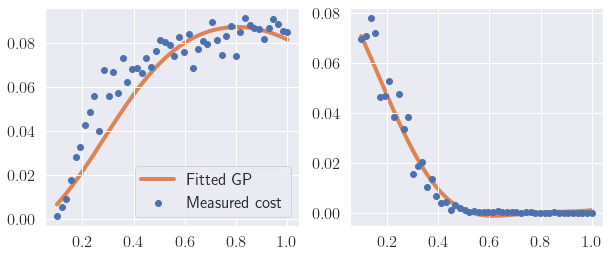

In [379]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(beta, observed_pred_beta, label="Fitted GP", color="C1", linewidth=4, zorder=0)
plt.scatter(beta, times_vs_beta, label="Measured cost")
plt.legend()

plt.subplot(1,2,2)
plt.plot(gamma, observed_pred_gamma, label="Fitted GP", color="C1", linewidth=4, zorder=0)
plt.scatter(gamma, times_vs_gamma, label="Measured cost")
plt.show()

In [14]:
prior_start = torch.tensor([0.1, 1.0]).reshape(-1, 2)
prior_end = torch.tensor([1.0, 0.1]).reshape(-1, 2)

g_min = likelihood(model(prior_start)).mean
g_max = likelihood(model(prior_end)).mean

print("g_min with k=0.5: ", (g_min ** 0.5).item())
print("g_min with k=1: ", (g_min ** 1).item())
print("g_min with k=2: ", (g_min ** 2).item())

print("g_max with k=0.5: ", (g_max ** 0.5).item())
print("g_max with k=1: ", (g_max ** 1).item())
print("g_max with k=2: ", (g_max ** 2).item())

g_min with k=0.5:  0.014827649109065533
g_min with k=1:  0.00021985918283462524
g_min with k=2:  4.833805888893039e-08
g_max with k=0.5:  0.2857629060745239
g_max with k=1:  0.0816604346036911
g_max with k=2:  0.006668426562100649


In [15]:
prior_start = torch.tensor([0.1, 1.0]).reshape(-1, 2)
k = 1

num_sim = 5000
theta_tilde = torch.zeros([num_sim, 2])
count = 0
while count < num_sim:
    theta = temp_sir.sample_theta([1]).reshape(-1, 2)
    if calc_acc_prob(model, likelihood, theta, prior_start, k) > torch.rand(1):
        theta_tilde[count] = theta.reshape(-1)
        count += 1
w = likelihood(model(theta_tilde)).mean.detach() ** k

theta_prior = temp_sir.sample_theta([num_sim]).reshape(-1, 2)

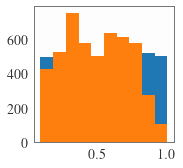

In [16]:
plt.hist(theta_prior.detach().numpy()[:, 0], bins=10)
plt.hist(theta_tilde.detach().numpy()[:, 0], bins=10)
plt.show()

## CEG ESS

In [23]:
num_sim = 10000
num_repeats = 2
k = np.array([0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]) # Exponent of the penaly function g(z) = z^k

ess_cost_aware = np.zeros([k.size, num_repeats])
ceg = np.zeros([k.size, num_repeats])

for ind in range(k.size):
    for j in range(num_repeats):
        
        if ind == 0:
            theta = temp_sir.sample_theta([num_sim])
            ess_cost_aware[ind, j] = 1
            ceg[ind, j] = 1
        else:
            # Sampling from cost-modified prior
            theta_tilde = torch.zeros([num_sim, 2])
            count = 0
            while count < num_sim:
                param_value = temp_sir.sample_theta([1]).reshape(-1, 2)
                if calc_acc_prob(model, likelihood, param_value, prior_start, k[ind]) > torch.rand(1):
                    theta_tilde[count] = param_value.reshape(-1)
                    count += 1

            w_u = likelihood(model(theta_tilde)).mean.detach() ** k[ind]   #self-normalised importance weights
            
            # Compute CEG
            ceg[ind, j] = torch.mean(likelihood(model(theta)).mean.detach()) / torch.mean(likelihood(model(theta_tilde)).mean.detach())
            # Compute ESS
            ess_cost_aware[ind, j] = ((w_u.sum())**2 / torch.square(w_u).sum()) / num_sim
print(ess_cost_aware * ceg)

## Train reference GP

In [20]:
# DON'T NEED TO RUN
temp_sir_inference_npe_large = SNPE_C()
temp_sir_nn_npe_large = temp_sir_inference_npe_large.append_simulations(
    temp_sir_theta_npe_large, temp_sir_x_npe_large).train()

prior, *_ = process_prior(temp_sir.prior)

temp_sir_post_npe_large = temp_sir_inference_npe_large.build_posterior(temp_sir_nn_npe_large, prior=prior)
temp_sir_post_reference = temp_sir_post_npe_large.sample((1000,), x=temp_sir_obs_x)

torch.save(temp_sir_post_reference, "data/temp_sir_post_reference.pt")

 Neural network successfully converged after 62 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
temp_sir_post_reference = torch.load("data_/temp_sir_post_reference.pt")

# Statistics over multiple runs

In [16]:
# C2ST - NPE
n_run = 50
c2st_npe = torch.zeros([n_run])
posterior_samples_npe = torch.zeros([n_run, 1000, 2])

for i in range(n_run):
    checkpoint_path = f"sims/temp_sir/1.0/{i+1}/ckpt.tar"
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

    posterior_npe = checkpoint["posterior_npe"]
    posterior_samples_npe[i] = posterior_npe.sample((1000,), x=temp_sir_obs_x, show_progress_bars=False)

    c2st_npe[i] = c2st(temp_sir_post_reference, posterior_samples_npe[i])

c2st_npe = c2st_npe.detach().numpy() 
c2st_npe_mean = np.mean(c2st_npe)
c2st_npe_std = np.std(c2st_npe)

print(f"NPE c2st mean {c2st_npe_mean:.2f} (std {c2st_npe_std:.2f})")

NPE c2st mean 0.60 (std 0.03)


In [17]:
# C2ST
def get_c2st_results(k, n_run):
    n_run = 50
    c2st_canpe = torch.zeros([n_run])
    posterior_samples_canpe = torch.zeros([n_run, 1000, 2])
    
    for i in range(n_run):
        checkpoint_path = f"sims/temp_sir/{k}/{i+1}/ckpt.tar"
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    
        posterior_canpe = checkpoint["posterior_canpe"]
        posterior_samples_canpe[i] = posterior_canpe.sample((1000,), x=temp_sir_obs_x, show_progress_bars=False)
    
        c2st_canpe[i] = c2st(temp_sir_post_reference, posterior_samples_canpe[i])
    
    c2st_canpe = c2st_canpe.detach().numpy() 
    c2st_canpe_mean = np.mean(c2st_canpe)
    c2st_canpe_std = np.std(c2st_canpe)
    
    print(f"CA-NPE c2st mean {c2st_canpe_mean:.2f} (std {c2st_canpe_std:.2f})")

In [18]:
get_c2st_results("0.5", 50)
get_c2st_results("1.0", 50)
get_c2st_results("2.0", 50)
get_c2st_results("mixture", 50)

CA-NPE c2st mean 0.66 (std 0.05)
CA-NPE c2st mean 0.70 (std 0.03)
CA-NPE c2st mean 0.75 (std 0.04)
CA-NPE c2st mean 0.65 (std 0.03)


### ks test

In [26]:
# KS - NPE
n_run = 50
ks_npe = torch.zeros([n_run, 2])
posterior_samples_npe = torch.zeros([n_run, 1000, 2])

for i in range(n_run):
    checkpoint_path = f"sims/temp_sir/1.0/{i+1}/ckpt.tar"
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

    posterior_npe = checkpoint["posterior_npe"]
    posterior_samples_npe[i] = posterior_npe.sample((1000,), x=temp_sir_obs_x, show_progress_bars=False)

    ks_npe[i] = torch.tensor(compute_ks_scores(temp_sir_post_reference, posterior_samples_npe[i]))

ks_npe = ks_npe.detach().numpy() 
ks_npe_mean = np.mean(ks_npe, axis=0)
ks_npe_std = np.std(ks_npe, axis=0)

print(f"NPE ks score mean {ks_npe_mean} (std {ks_npe_std})")

NPE ks score mean [0.12311998 0.12288   ] (std [0.06305192 0.05831591])


In [27]:
def get_ks_results(k, n_run):
    n_run = 50
    ks_canpe = torch.zeros([n_run, 2])
    posterior_samples_canpe = torch.zeros([n_run, 1000, 2])
    
    for i in range(n_run):
        checkpoint_path = f"sims/temp_sir/{k}/{i+1}/ckpt.tar"
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    
        posterior_canpe = checkpoint["posterior_canpe"]
        posterior_samples_canpe[i] = posterior_canpe.sample((1000,), x=temp_sir_obs_x, show_progress_bars=False)

        ks_canpe[i] = torch.tensor(compute_ks_scores(temp_sir_post_reference, posterior_samples_canpe[i]))
    
    ks_canpe = ks_canpe.detach().numpy() 
    ks_canpe_mean = np.mean(ks_canpe, axis=0)
    ks_canpe_std = np.std(ks_canpe, axis=0)
    
    print(f"CA-NPE ks mean {ks_canpe_mean} (std {ks_canpe_std})")

In [28]:
get_ks_results("0.5", 50)
get_ks_results("1.0", 50)
get_ks_results("2.0", 50)
get_ks_results("mixture", 50)

CA-NPE ks mean [0.11386    0.13365999] (std [0.04561404 0.05604877])
CA-NPE ks mean [0.13272 0.13162] (std [0.04903225 0.06652365])
CA-NPE ks mean [0.13425998 0.18570001] (std [0.06950419 0.07139279])
CA-NPE ks mean [0.11857998 0.13006002] (std [0.04385708 0.05555192])


In [276]:
# NPE results
n_run = 100
mmd_npe = torch.zeros([n_run])
posterior_samples_npe = torch.zeros([n_run, 1000, 2])
cost_npe = torch.zeros([n_run])

for i in range(n_run):
    checkpoint_path = f"sims/temp_sir/gp_coarse/2.0/{i+1}/ckpt.tar"
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

    posterior_npe = checkpoint["posterior_npe"]
    posterior_samples_npe[i] = posterior_npe.sample((1000,), x=temp_sir_obs_x, show_progress_bars=False)
    
    mmd_npe[i] = MMD_unweighted(posterior_samples_npe[i], temp_sir_post_reference, lengthscale=median_heuristic(temp_sir_post_reference))

mmd_npe = mmd_npe.detach().numpy() 
mmd_npe_mean = np.mean(mmd_npe)
mmd_npe_std = np.std(mmd_npe)

print(f"NPE MMD mean {mmd_npe_mean:.2f} (std {mmd_npe_std:.2f})")

NPE MMD mean 0.07 (std 0.02)


In [11]:
median_heuristic(temp_sir_post_reference)

tensor(0.1881)

In [384]:
def get_results(k, n_run):
    mmd_canpe = torch.zeros([n_run])
    posterior_samples_canpe = torch.zeros([n_run, 1000, 2])
    cost_canpe = torch.zeros([n_run])
    cost_saved = torch.zeros([n_run])
    
    for i in range(n_run):
        checkpoint_path = f"sims/temp_sir/gp_coarse/{k}/{i+1}/ckpt.tar"
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
        posterior_canpe = checkpoint["posterior_canpe"]

        posterior_samples_canpe[i] = posterior_canpe.sample((1000,), x=temp_sir_obs_x, show_progress_bars=False)

        mmd_canpe[i] = MMD_unweighted(posterior_samples_canpe[i], temp_sir_post_reference, lengthscale=median_heuristic(temp_sir_post_reference))
        cost_npe[i] = torch.tensor(checkpoint["cost_npe"])
        cost_canpe[i] = torch.tensor(checkpoint["cost_canpe"])
        cost_saved[i] = 1 - cost_canpe[i] / cost_npe[i]
            
    mmd_canpe = mmd_canpe.detach().numpy() 
    mmd_canpe_mean = np.mean(mmd_canpe)
    mmd_canpe_std = np.std(mmd_canpe)

    cost_canpe = cost_canpe.detach().numpy() 
    cost_canpe_mean = np.mean(cost_canpe)
    cost_canpe_std = np.std(cost_canpe)
    
    cost_saved = cost_saved.detach().numpy()
    cost_saved_mean = np.mean(cost_saved)
    cost_saved_std = np.std(cost_saved)
    
    print(f"CA-NPE MMD mean {mmd_canpe_mean:.2f} (std {mmd_canpe_std:.2f})")
    # print(f"CA-NPE cost mean {cost_canpe_mean:.2f} (std {cost_canpe_std:.2f})")
    print(f"Cost saved: {cost_saved_mean:.2f}(std {cost_saved_std:.2f})")

In [139]:
temp_sir_obs_theta = torch.tensor([0.5, 0.5])
temp_sir_obs_x = temp_sir(temp_sir_obs_theta)
temp_sir_obs_x

tensor([  1.0000,   1.0000,   3.0000,   1.0000,   0.0000,   0.0000,   0.0000,
          2.0000,   4.0000,   4.0000,  16.0000, 108.7057])

In [279]:
temp_sir_obs_x

tensor([  1.0000,   1.0000,   3.0000,   1.0000,   0.0000,   0.0000,   0.0000,
          2.0000,   4.0000,   4.0000,  16.0000, 108.7057])

In [416]:
get_results('0.5', 100)

CA-NPE MMD mean 0.05 (std 0.03)
Cost saved: 0.08(std 0.03)


In [417]:
get_results('1.0', 100)

CA-NPE MMD mean 0.06 (std 0.03)
Cost saved: 0.33(std 0.02)


In [418]:
get_results('2.0', 100)

CA-NPE MMD mean 0.08 (std 0.03)
Cost saved: 0.69(std 0.01)


In [419]:
get_results('multiple', 100)

CA-NPE MMD mean 0.05 (std 0.02)
Cost saved: 0.15(std 0.03)


# Different cost function approximations

## GP with 200 points

In [68]:
cost_gp_200 = np.zeros([N, N])
cost_gp_200 = likelihood(model(torch.tensor(theta_grid).float())).mean.reshape(N, N)

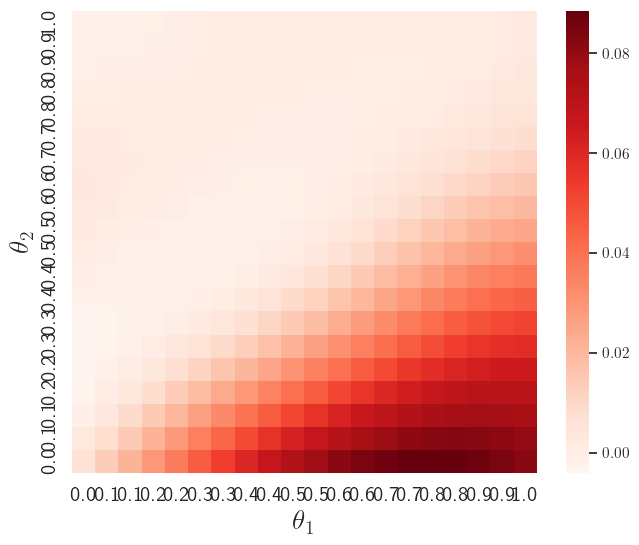

In [69]:
beta_range = np.linspace(0, 1, N)
gamma_range = np.linspace(0, 1, N)
sns.set(style="white")

plt.figure(figsize=(7.5, 6))
sns.heatmap(cost_gp_200.detach().numpy(), xticklabels=np.round(beta_range, 1), yticklabels=np.round(gamma_range, 1), annot=False, fmt=".2f", cmap='Reds').invert_yaxis()
plt.xlabel('$\\theta_1$', size=20)
plt.ylabel('$\\theta_2$', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## GP with 15 points

In [ ]:
# For GP with 15 points
X_15 = X[:15]
times_train_15 = times_train[:15]

torch.save(X_15, "data/temp_sir_gp_x_15.pt")
torch.save(times_train_15, "data/temp_sir_gp_y_15.pt")

In [70]:
X_15 = torch.load("data/temp_sir_gp_x_15.pt")
times_train_15 = torch.load("data/temp_sir_gp_y_15.pt")

In [404]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X_15, times_train_15, likelihood)
model.float()
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 200
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_15.float())
    loss = -mll(output, times_train_15)
    loss.backward()
    optimizer.step()
    print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item()}')

torch.save({'model_state_dict': model.state_dict(), 'likelihood_state_dict': likelihood.state_dict()}, 'data/temp_sir_gp_15.pth')

Iter 1/200 - Loss: 0.8878328204154968
Iter 2/200 - Loss: 0.8467208743095398
Iter 3/200 - Loss: 0.8045788407325745
Iter 4/200 - Loss: 0.7624120712280273
Iter 5/200 - Loss: 0.7199354767799377
Iter 6/200 - Loss: 0.6768052577972412
Iter 7/200 - Loss: 0.6332358717918396
Iter 8/200 - Loss: 0.589387059211731
Iter 9/200 - Loss: 0.5451001524925232
Iter 10/200 - Loss: 0.5002228021621704
Iter 11/200 - Loss: 0.45487794280052185
Iter 12/200 - Loss: 0.409198135137558
Iter 13/200 - Loss: 0.3630770444869995
Iter 14/200 - Loss: 0.3164028823375702
Iter 15/200 - Loss: 0.269311785697937
Iter 16/200 - Loss: 0.22190506756305695
Iter 17/200 - Loss: 0.17404048144817352
Iter 18/200 - Loss: 0.12571881711483002
Iter 19/200 - Loss: 0.07712148129940033
Iter 20/200 - Loss: 0.02817554399371147
Iter 21/200 - Loss: -0.02118701860308647
Iter 22/200 - Loss: -0.07076682895421982
Iter 23/200 - Loss: -0.12064635008573532
Iter 24/200 - Loss: -0.17084598541259766
Iter 25/200 - Loss: -0.22118332982063293
Iter 26/200 - Loss: -

In [71]:
state_dicts = torch.load('data/temp_sir_gp_15.pth')   # Load GP params

# Load GP data
X = torch.load("data/temp_sir_gp_x_15.pt")
times_train = torch.load("data/temp_sir_gp_y_15.pt")

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)

model.load_state_dict(state_dicts['model_state_dict'])
likelihood.load_state_dict(state_dicts['likelihood_state_dict'])

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [72]:
cost_gp_15 = likelihood(model(torch.tensor(theta_grid).float())).mean.reshape(N, N)

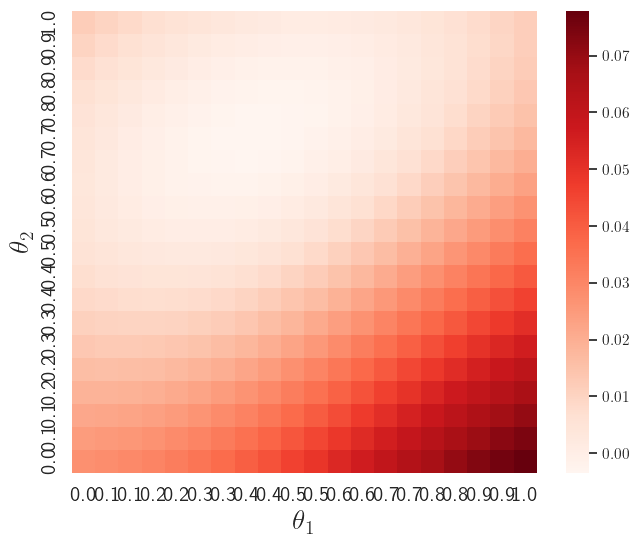

In [73]:
beta_range = np.linspace(0, 1, N)
gamma_range = np.linspace(0, 1, N)
sns.set(style="white")

plt.figure(figsize=(7.5, 6))
sns.heatmap(cost_gp_15.detach().numpy(), xticklabels=np.round(beta_range, 1), yticklabels=np.round(gamma_range, 1), annot=False, fmt=".2f", cmap='Reds').invert_yaxis()
plt.xlabel('$\\theta_1$', size=20)
plt.ylabel('$\\theta_2$', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Linear cost function

In [31]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, times_train)

a_1, a_2 = model.coef_ 
b = model.intercept_ 

# np.save("data/temp_sir_linear_a1.npy", a_1)
# np.save("data/temp_sir_linear_a2.npy", a_2)
# np.save("data/temp_sir_linear_b.npy", b)

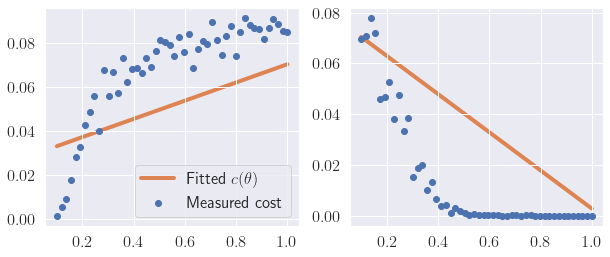

In [392]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(beta, a_1 * beta + a_2 * 0.1 + b, label="Fitted $c(\\theta)$", color="C1", linewidth=4, zorder=0)
plt.scatter(beta, times_vs_beta, label="Measured cost")
plt.legend()

plt.subplot(1,2,2)
plt.plot(gamma, a_1 * 1 + a_2 * gamma + b, label="Fitted $c(\\theta)$", color="C1", linewidth=4, zorder=0)
plt.scatter(gamma, times_vs_gamma, label="Measured cost")
plt.show()

In [55]:
def linear_step(beta, gamma):
    cost = a_1 * beta + a_2 * gamma + b
    return cost if cost > 0.02 else 0.02

In [74]:
a_1 = np.load("data/temp_sir_linear_a1.npy")
a_2 = np.load("data/temp_sir_linear_a2.npy")
b   = np.load("data/temp_sir_linear_b.npy")

cost_linear = np.zeros([N, N])
for i in range(N):
    for j in range(N):
        cost_linear[i, j] = linear_step(beta_range[i], gamma_range[j])

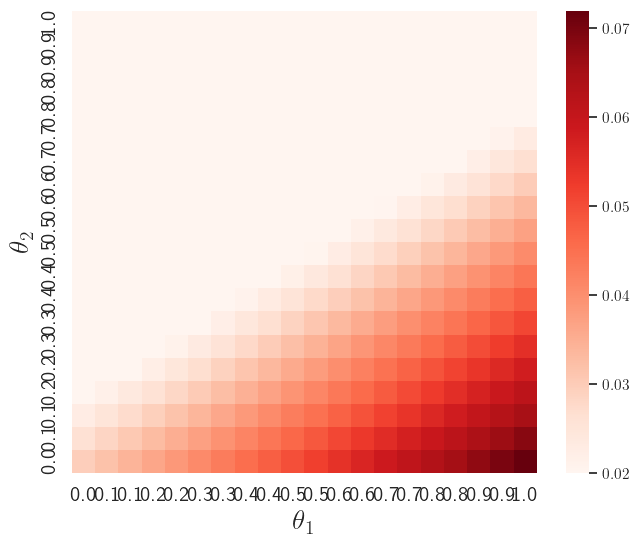

In [75]:
beta_range = np.linspace(0, 1, N)
gamma_range = np.linspace(0, 1, N)
sns.set(style="white")

plt.figure(figsize=(7.5, 6))
sns.heatmap(cost_linear.T, xticklabels=np.round(beta_range, 1), yticklabels=np.round(gamma_range, 1), annot=False, fmt=".2f", cmap='Reds').invert_yaxis()
plt.xlabel('$\\theta_1$', size=20)
plt.ylabel('$\\theta_2$', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Real cost function

In [23]:
N = 20
n_rep = 50

beta_range = np.linspace(0.1, 1, N)
gamma_range = np.linspace(0.1, 1, N)

beta_grid, gamma_grid = np.meshgrid(beta_range, gamma_range)
theta_grid = np.hstack((beta_grid.reshape(-1, 1), gamma_grid.reshape(-1, 1)))

cost_real = np.zeros([N, N])

In [ ]:
for i in range(N):
    for j in range(N):
        st = time.time()
        for _ in range(n_rep):
            result = temp_sir(torch.tensor([beta_range[i], gamma_range[j]]))
        et = time.time()
        cost_real[i, j] = (et - st) / n_rep

np.save("data_/temporal_sir_cost_fig1_new.npy", cost_real)

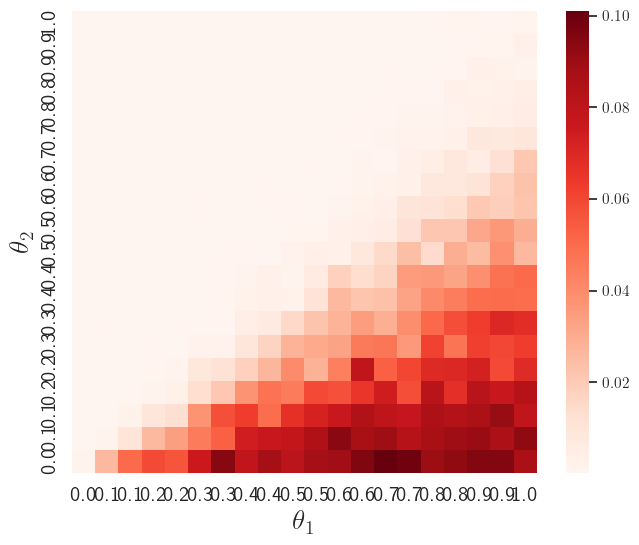

In [76]:
cost_real = np.load("data_/temporal_sir_cost_fig1_new.npy")

beta_range = np.linspace(0, 1, N)
gamma_range = np.linspace(0, 1, N)
sns.set(style="white")

plt.figure(figsize=(7.5, 6))
sns.heatmap(cost_real.T, xticklabels=np.round(beta_range, 1), yticklabels=np.round(gamma_range, 1), annot=False, fmt=".2f", cmap='Reds').invert_yaxis()
plt.xlabel('$\\theta_1$', size=20)
plt.ylabel('$\\theta_2$', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Figure 1

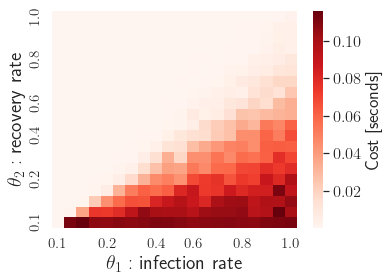

In [413]:
import seaborn as sns
sns.set(rc={'text.usetex': True})
import matplotlib.ticker as ticker

x_lab = np.array(['$0.1$', "", "", "", '$0.2$', "", "", "", '$0.4$', "", "" "", '$0.6$', "", "", "", '$0.8$', "", "", "", '$1.0$'])
y_lab = np.array(['$0.1$', "", "", "", '$0.2$', "", "", "", '$0.4$', "", "" "", '$0.6$', "", "", "", '$0.8$', "", "", "", '$1.0$'])

N = 20
beta_range = np.linspace(0.1, 1, N)
gamma_range = np.linspace(0.1, 1, N)

sns.set(style="white")
sns.set(font_scale=1.5)

plt.figure(figsize=(5.5, 4))
ax = sns.heatmap(cost_real.T, xticklabels=x_lab, yticklabels=y_lab,
                    annot=False, cmap="Reds", cbar_kws={'label': 'Cost [seconds]'}).invert_yaxis()
plt.xlabel('$\\theta_1:$ infection rate', size=20)
plt.ylabel('$\\theta_2:$ recovery rate', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig("figures/plot_intro.pdf", bbox_inches='tight', dpi = 300, format="pdf")
plt.show()

In [77]:
cost_real = cost_real.T
cost_linear = cost_linear.T
cost_gp_200 = cost_gp_200.detach().numpy()
cost_gp_15 = cost_gp_15.detach().numpy()

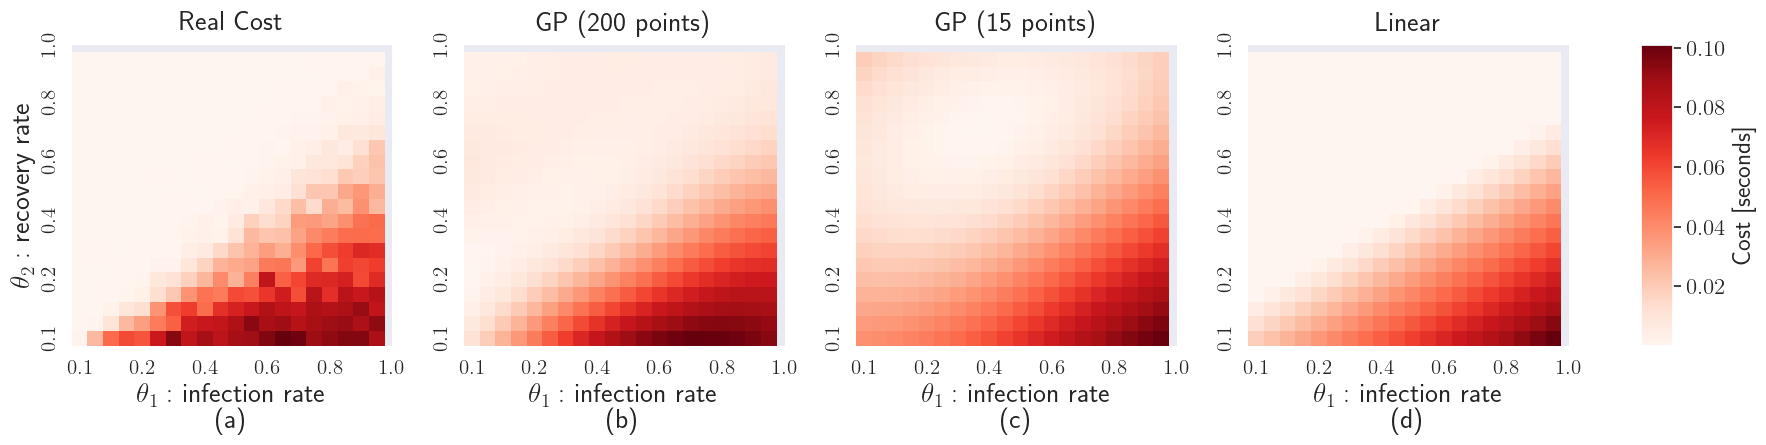

In [82]:
import matplotlib.gridspec as gridspec

# Set up Seaborn with usetex enabled
sns.set(rc={'text.usetex': True})
sns.set(style="white")
sns.set(font_scale=1.5)

# Axis tick labels
x_lab = np.array(['$0.1$', "", "", "", '$0.2$', "", "", "", '$0.4$', "", "", "", '$0.6$', "", "", "", '$0.8$', "", "", "", '$1.0$'])
y_lab = np.array(['$0.1$', "", "", "", '$0.2$', "", "", "", '$0.4$', "", "", "", '$0.6$', "", "", "", '$0.8$', "", "", "", '$1.0$'])

# Create figure and grid: 1 row, 5 columns (last for colorbar)
fig = plt.figure(figsize=(18, 5))
gs = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 0.1])

top_titles = ['Real Cost', 'GP (200 points)', 'GP (15 points)', 'Linear']
subfigure_labels = ['(a)', '(b)', '(c)', '(d)']
data_matrices = [cost_real, cost_gp_200, cost_gp_15, cost_linear]
axes = []

for idx, (top_title, data, label) in enumerate(zip(top_titles, data_matrices, subfigure_labels)):
    ax = plt.subplot(gs[idx])
    im = sns.heatmap(data, xticklabels=x_lab, yticklabels=y_lab,
                     annot=False, cmap="Reds", cbar=False, ax=ax)
    ax.invert_yaxis()

    # Top title and x-axis label for all subplots
    ax.set_title(top_title, fontsize=20, pad=10)
    ax.set_xlabel('$\\theta_1:$ infection rate', fontsize=20)
    
    # Only the leftmost subplot gets a y-axis label
    if idx == 0:
        ax.set_ylabel('$\\theta_2:$ recovery rate', fontsize=20)
    else:
        ax.set_ylabel('')
    
    # Bottom subfigure label
    ax.text(0.5, -0.25, label, transform=ax.transAxes,
            ha='center', va='center', fontsize=20)
    
    ax.tick_params(labelsize=15)
    axes.append(ax)

# Add a colorbar on the right
cax = plt.subplot(gs[4])
fig.colorbar(axes[0].collections[0], cax=cax, label='Cost [seconds]')

plt.tight_layout()
plt.savefig("figures/cost_func_comparison.pdf", bbox_inches='tight', dpi=300)
plt.show()


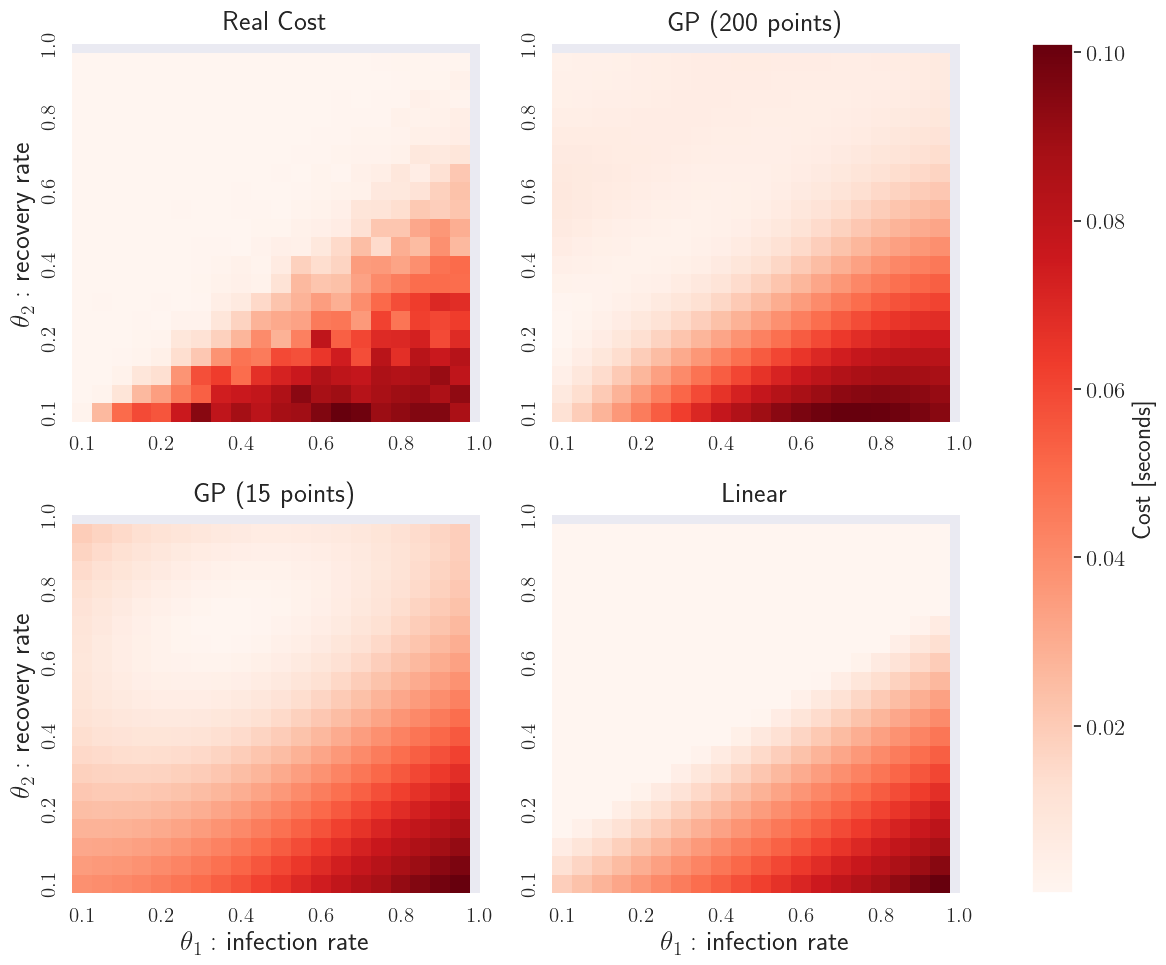

In [81]:
# 2*2 old code
import matplotlib.gridspec as gridspec

# Setup
sns.set(rc={'text.usetex': True})
sns.set(style="white")
sns.set(font_scale=1.5)

# Create labels
x_lab = np.array(['$0.1$', "", "", "", '$0.2$', "", "", "", '$0.4$', "", "", "", '$0.6$', "", "", "", '$0.8$', "", "", "", '$1.0$'])
y_lab = np.array(['$0.1$', "", "", "", '$0.2$', "", "", "", '$0.4$', "", "", "", '$0.6$', "", "", "", '$0.8$', "", "", "", '$1.0$'])

# Create figure with custom grid
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.1])

# Create the four subplots
titles = ['Real Cost', 'GP (200 points)', 'GP (15 points)', 'Linear']
data_matrices = [cost_real, cost_gp_200, cost_gp_15, cost_linear]
axes = []

for idx, (title, data) in enumerate(zip(titles, data_matrices)):
    row = idx // 2
    col = idx % 2
    ax = plt.subplot(gs[row, col])
    
    # Create heatmap
    im = sns.heatmap(data, xticklabels=x_lab, yticklabels=y_lab,
                     annot=False, cmap="Reds", cbar=False)
    im.invert_yaxis()
    
    # Set labels and title
    if row == 1:  # Bottom row
        plt.xlabel('$\\theta_1:$ infection rate', size=20)
    if col == 0:  # Left column
        plt.ylabel('$\\theta_2:$ recovery rate', size=20)
    plt.title(title, size=20, pad=10)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    axes.append(im)

# Add a single colorbar on the right
cax = plt.subplot(gs[:, -1])
fig.colorbar(axes[0].get_children()[0], cax=cax, label='Cost [seconds]')

# Adjust layout
plt.tight_layout()
plt.savefig("figures/cost_comparison.pdf", bbox_inches='tight', dpi=300)
plt.show()